## E20 - 다른 시계열 데이터에서 이상치를 찾아보자

### Step 1. 데이터 구하기

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import requests
import os

# 미국 나스닥
url = 'https://query1.finance.yahoo.com/v7/finance/download/NQ=F?period1=969235200&period2=1603152000&interval=1d&events=history'

response = requests.get(url)

csv_file = os.getenv('HOME') + '/aiffel/anomaly_detection/nasdaq/nasdaq.csv'

with open(csv_file, 'w') as fp:
    fp.write(response.text)

In [2]:
df = pd.read_csv(csv_file)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0
2,2000-09-20,3801.5,3874.0,3715.5,3853.0,3853.0,78832.0
3,2000-09-21,3852.0,3874.0,3744.0,3765.0,3765.0,70719.0
4,2000-09-22,3673.0,3780.0,3615.0,3776.0,3776.0,55926.0


In [3]:
# 날짜데이터를 Datetime형을 캐스팅
df.loc[:, 'Date'] = pd.to_datetime(df.Date)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6166 entries, 0 to 6165
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       6166 non-null   datetime64[ns]
 1   Open       5094 non-null   float64       
 2   High       5094 non-null   float64       
 3   Low        5094 non-null   float64       
 4   Close      5094 non-null   float64       
 5   Adj Close  5094 non-null   float64       
 6   Volume     5094 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 337.3 KB


In [4]:
# 중복데이터 유무 확인하기
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [5]:
print('삭제 전 데이터 길이(일자수):', len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print('삭제 후 데이터 길이(일자수):', len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6166
삭제 후 데이터 길이(일자수): 5094


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Step 2. 기본 통계분석으로 이상치 찾기

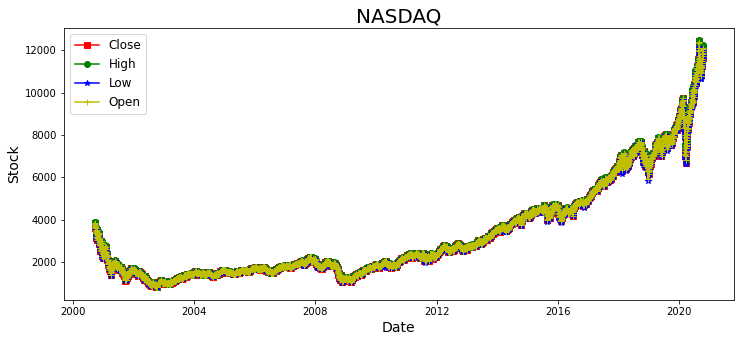

In [6]:
plt.figure(figsize=(12, 5))

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ', fontsize=20)
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

그래프 상에선 이상치가 발견되지 않는다.  
z-test로 정규분포 여부 확인하기

In [7]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


p가 0이 나와서 정규 분포로 가정한 통계적 추정이 어려우므로  
time series decomposition해서 시계열 데이터를 분리한다.

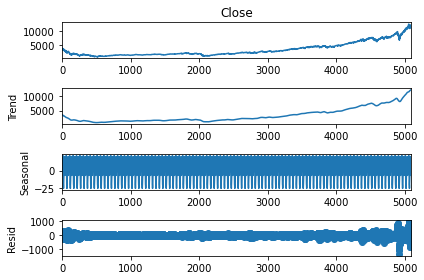

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True,
                            period=50, extrapolate_trend='freq')
result.plot()
plt.show()

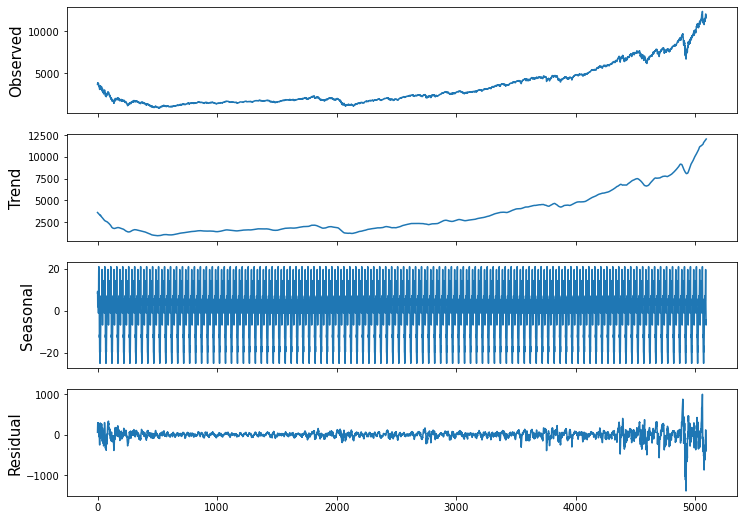

In [9]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed', fontsize=15)
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend', fontsize=15)
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal', fontsize=15)
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual', fontsize=15)
plt.show()

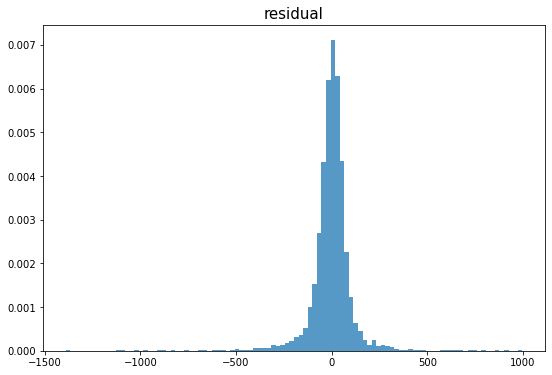

In [10]:
fit, ax = plt.subplots(figsize=(9, 6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)
plt.title('residual', fontsize=15)
plt.show()

In [11]:
r = result.resid.values
st, p = ztest(r)
print(st, p)

-0.8942734929026334 0.37117557875830953


z-test결과에서도 알 수 있듯이 정규분포가 가능하다.
이제 평균에서 3σ를 벗어나는 데이터 찾기

In [12]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print('평균:', mu, '표준편차:', std)

# 3σ를 벗어나는 데이터
print('이상치 갯수:', len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -1.3857940518773666 표준편차: 110.60068205120827
이상치 갯수: 93


In [30]:
df.Date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

66     2000-12-20
73     2001-01-02
91     2001-01-29
92     2001-01-30
136    2001-04-03
          ...    
5083   2020-10-05
5084   2020-10-06
5085   2020-10-07
5086   2020-10-08
5093   2020-10-19
Name: Date, Length: 93, dtype: datetime64[ns]

2001년 미국 경기침체, 2008년 금융위기, 2020년 코로나 영향으로 주가 하락으로 보여지며  
극단치가 아닌 특이치로 예상이 된다.  
### Step 3. Unsupervised Clustering 으로 이상치 찾기

In [31]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,3324.303285,3355.663089,3292.204015,3326.157530,287799.978783
std,2390.871506,2412.479986,2369.858940,2394.718369,109505.690572
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.251875,1597.572500,1571.058750,1584.191100,220550.460000
50%,2263.775000,2291.211250,2231.463750,2264.287900,268829.760000
75%,4433.603750,4464.010625,4399.788125,4434.981250,319616.697500
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [32]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-1.494218,-1.447168,-1.394948,-1.402187,151.569395
std,113.106458,102.570229,117.278403,110.763008,110728.081183
min,-1280.163546,-1494.231533,-1226.595518,-1389.770659,-602995.916675
25%,-37.912202,-35.100432,-38.323649,-37.371552,-53378.364320
50%,3.575670,3.350366,4.153527,2.958782,-550.641229
75%,40.353926,37.613888,42.048756,40.813609,51586.933556
max,996.821566,933.584382,941.409836,996.232816,810709.568301


In [33]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.49421837  -1.44716848  -1.39494753  -1.40218679 151.56939522]


array([[ 0.94173218,  0.84218124,  0.81160865,  0.59799575,  0.08320961],
       [ 0.48655464,  1.27770882,  1.3787828 ,  2.08212326,  0.10452718],
       [ 1.89305329,  2.00817542,  2.03390849,  2.72037058, -0.08886831],
       ...,
       [-0.65531897, -1.82608069, -0.96473553, -1.32833825,  0.28432658],
       [-1.31334711, -1.62375976, -0.70348768, -2.17905108, -0.36418376],
       [-2.12456827, -2.48917183, -2.57191425, -3.70655626,  0.57687603]])

#### K-means로 분석하기

In [45]:
# K-means로 정상인 데이터와 이상치를 분류하기
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1040',
 'group:1-count:74',
 'group:2-count:742',
 'group:3-count:106',
 'group:4-count:311',
 'group:5-count:397',
 'group:6-count:1046',
 'group:7-count:31',
 'group:8-count:20',
 'group:9-count:262',
 'group:10-count:438',
 'group:11-count:13',
 'group:12-count:35',
 'group:13-count:97',
 'group:14-count:482']

In [55]:
# 어떤 날들일까? 
df[(kmeans.labels_==11)|(kmeans.labels_==7)|(kmeans.labels_==12)]

,Date,Open,High,Low,Close,Adj Close,Volume
137,2001-04-04,1407.500000,1451.000000,1361.000000,1379.500000,1379.500000,141811.0
845,2004-01-15,1532.000000,1548.500000,1516.000000,1537.500000,1537.500000,487414.0
846,2004-01-16,1536.500000,1556.000000,1535.500000,1553.000000,1553.000000,487414.0
1639,2007-02-27,1837.500000,1838.250000,1744.250000,1750.500000,1750.500000,774124.0
1742,2007-07-26,2026.500000,2039.500000,1969.250000,2000.500000,2000.500000,808824.0
...,...,...,...,...,...,...,...
5083,2020-10-05,11308.500000,11497.500000,11267.500000,11469.200195,11469.200195,398444.0
5084,2020-10-06,11473.000000,11524.500000,11197.500000,11273.799805,11273.799805,612278.0
5085,2020-10-07,11220.500000,11506.500000,11208.000000,11470.000000,11470.000000,443046.0
5086,2020-10-08,11473.200195,11578.799805,11469.799805,11539.000000,11539.000000,403379.0


In [56]:
df[(kmeans.labels_==8)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


In [49]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000,5.094000e+03
mean,3322.800450,3354.209317,3290.797495,3324.746141,3324.746141,2.879739e+05
std,2390.480458,2411.646052,2370.093040,2394.337534,2394.337534,1.594162e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1592.812500,1608.312500,1576.500000,1593.000000,1593.000000,1.906860e+05
50%,2229.625000,2257.375000,2210.750000,2230.250000,2230.250000,2.656720e+05
75%,4445.000000,4464.687500,4417.875000,4448.250000,4448.250000,3.558778e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [50]:
# 각 그룹은 어떤 특징을 가지고 있을까?

pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,0.208734,0.210396,0.265769,0.249790,-0.406729
1,-1.553192,-1.667173,-2.103025,-2.062452,2.750833
2,0.352775,0.382333,0.291303,0.306922,0.506777
3,2.293611,2.380824,2.415479,2.376406,-0.438564
4,-0.186571,-0.213582,-0.418386,-0.402497,1.528749
5,-0.413290,-0.462715,-0.328959,-0.369733,-0.960155
6,-0.191460,-0.191263,-0.182387,-0.178142,0.219125
7,-4.262138,-4.603683,-4.243449,-4.319169,0.501229
8,6.027197,6.084572,6.079186,6.001044,-0.221431
9,0.259411,0.254501,0.316326,0.305125,-1.922633


7, 11번 그룹이 많이 하락했고, 8번 그룹이 많이 올랐다.

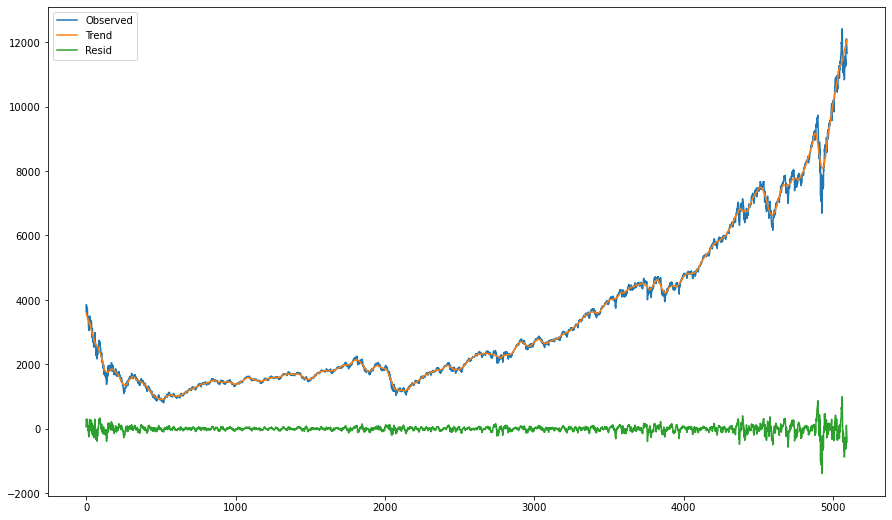

In [51]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

7번, 11번, 12번 그룹은 2001년 it버블 붕괴, 2007년 서브프라임 모기지 사태, 2008년 금융위기, 2020년 코로나 영향으로 보인다.  
8번 그룹은 과도한 하락으로 인한 반등으로 보여진다. 
주식에서 흔히 볼 수 있는 예상치 못한 특이치에 해당한다.
#### DBSCAN으로 분석하기

In [126]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.6, min_samples=4).fit(norm_rdf)
clustering

DBSCAN(eps=0.6, min_samples=4)

In [127]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:315',
 'group:0-count:4705',
 'group:1-count:65',
 'group:2-count:5',
 'group:3-count:4']

In [132]:
df[(clustering.labels_==1)]

,Date,Open,High,Low,Close,Adj Close,Volume
2,2000-09-20,3801.5,3874.0,3715.500000,3853.000000,3853.000000,78832.0
3,2000-09-21,3852.0,3874.0,3744.000000,3765.000000,3765.000000,70719.0
5,2000-09-25,3776.5,3830.0,3660.000000,3675.000000,3675.000000,51490.0
8,2000-09-28,3640.5,3780.0,3607.000000,3758.000000,3758.000000,61459.0
9,2000-09-29,3730.0,3742.5,3608.000000,3621.000000,3621.000000,57397.0
...,...,...,...,...,...,...,...
4887,2020-02-06,9390.0,9464.0,9362.500000,9455.500000,9455.500000,545054.0
4888,2020-02-07,9467.0,9471.0,9385.000000,9409.500000,9409.500000,592695.0
5012,2020-07-07,10600.0,10694.5,10505.799805,10532.200195,10532.200195,465212.0
5013,2020-07-08,10526.0,10673.0,10505.200195,10662.200195,10662.200195,481023.0


### Step 4. LSTM 오토인코더로 이상치 찾기

In [133]:
# 필요한 라이브러리를 불러옵니다

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [134]:
# 모델 재현성을 위해 난수 시드설정을 해줍니다
tf.random.set_seed(777)
np.random.seed(777)

In [135]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [136]:
# keras TimeseriesGenerator 를 이용해서 데이터셋 만들기

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [157]:
# 모델 만들기

model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='sigmoid', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='sigmoid', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='sigmoid', return_sequences=True),
    LSTM(64, activation='sigmoid', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10, 64)            17920     
_________________________________________________________________
lstm_17 (LSTM)               (None, 16)                5184      
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 10, 16)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 10, 16)            2112      
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
__________________________________________________

In [158]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [159]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 2.0927 - mae: 2.0927
Epoch 00001: val_loss improved from inf to 4.86606, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 31ms/step - loss: 2.0927 - mae: 2.0927 - val_loss: 4.8661 - val_mae: 4.8661
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 1.7660 - mae: 1.7660
Epoch 00002: val_loss improved from 4.86606 to 2.80808, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 30ms/step - loss: 1.7660 - mae: 1.7660 - val_loss: 2.8081 - val_mae: 2.8081
Epoch 3/50
159/159 [==============================] - ETA: 0s - loss: 1.2158 - mae: 1.2158
Epoch 00003: val_loss improved from 2.80808 to 2.20883, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymodel.ckpt
159/159 [==============================] - 5s 29ms/step - loss: 1.2158 - mae: 1.2158 

159/159 [==============================] - ETA: 0s - loss: 0.3249 - mae: 0.3249
Epoch 00027: val_loss did not improve from 0.32610
159/159 [==============================] - 5s 29ms/step - loss: 0.3249 - mae: 0.3249 - val_loss: 0.6736 - val_mae: 0.6736
Epoch 28/50
159/159 [==============================] - ETA: 0s - loss: 0.3223 - mae: 0.3223
Epoch 00028: val_loss did not improve from 0.32610
159/159 [==============================] - 5s 29ms/step - loss: 0.3223 - mae: 0.3223 - val_loss: 0.3450 - val_mae: 0.3450
Epoch 29/50
159/159 [==============================] - ETA: 0s - loss: 0.2815 - mae: 0.2815
Epoch 00029: val_loss did not improve from 0.32610
159/159 [==============================] - 5s 29ms/step - loss: 0.2815 - mae: 0.2815 - val_loss: 0.4336 - val_mae: 0.4336
Epoch 30/50
159/159 [==============================] - ETA: 0s - loss: 0.2939 - mae: 0.2939
Epoch 00030: val_loss improved from 0.32610 to 0.32563, saving model to /home/aiffel0042/aiffel/anomaly_detection/nasdaq/mymo

In [160]:
model.load_weights(checkpoint_path)

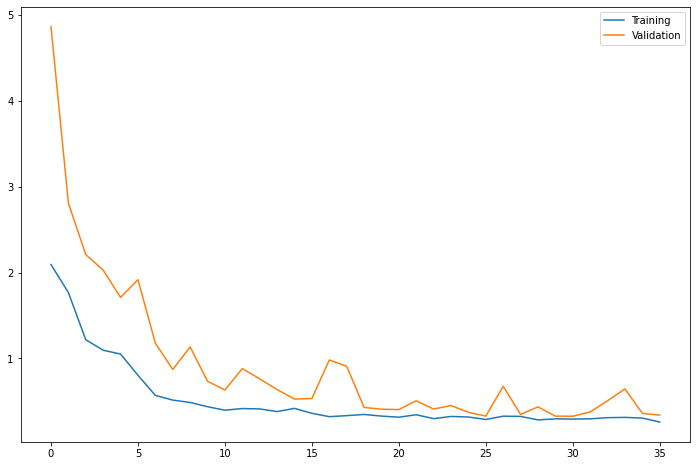

In [161]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

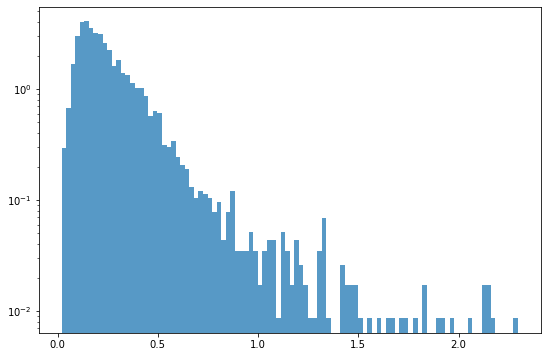

In [162]:
# 예측 결과를 pred 로, 실제 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [168]:
# 무리와 동떨어진 데이터가 보인다.
# mae_loss의 기준치를 0.9로 해서 분석한다.

import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 0.9
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1629,2007-02-27,1837.500000,1838.250000,1744.250000,1750.500000,1750.500000,774124.0,0.992928
1732,2007-07-26,2026.500000,2039.500000,1969.250000,2000.500000,2000.500000,808824.0,1.014064
1747,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.328331
1806,2007-11-08,2175.000000,2180.000000,2081.000000,2105.500000,2105.500000,884081.0,1.192980
1853,2008-01-22,1851.500000,1858.250000,1744.500000,1801.000000,1801.000000,751476.0,0.952133
...,...,...,...,...,...,...,...,...
5079,2020-10-13,12100.000000,12249.000000,12019.000000,12094.000000,12094.000000,754735.0,1.964677
5080,2020-10-14,12079.799805,12178.000000,11901.799805,11974.200195,11974.200195,597198.0,1.602471
5081,2020-10-15,11950.000000,11983.200195,11736.500000,11874.000000,11874.000000,595926.0,1.431156
5082,2020-10-16,11891.000000,12022.000000,11792.000000,11798.000000,11798.000000,527026.0,1.465991


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


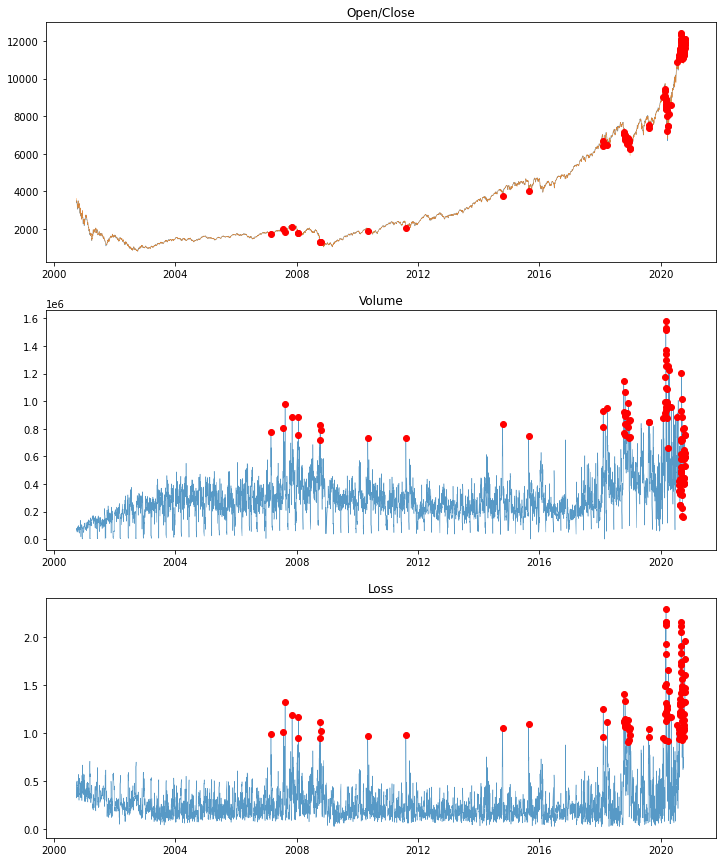

In [169]:
# 이상치는 붉은 점

fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

통계적 방법과 Unsupervised clustering 방법은 정규 분포나 군집을 이용하기 때문에  
데이터를 온전히 사용하지 못하는 단점이 있어 자세히 분석하지 못한 것 같고   
딥러닝을 이용한 경우에는 trend, seansonal도 포함한 데이터를 전부 이용하여 분석하여서  
제법 이상치를 잘 파악한 것 같다.